# Forecast Exploration Notebook

This notebook is used for the initial setup of the GluonTS DeepAR workflow. <br />It includes loading the engineered time series, converting them into a time series (here I looked at both Pandas and List Datasets from GluonTS), model training and finally running backtests and evaluation.


## Config Setup


To keep track of experiments, their configuration and result is stored in a SQLlite database.


In [78]:
from sqlalchemy import create_engine, Column, Integer, Float, String, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

In [79]:
# Define table schema
Base = declarative_base()


class Forecast_Experiment(Base):
    __tablename__ = "forecast_experiment"
    id = Column("id", Integer, primary_key=True)
    model = Column("model name", String(20))
    target = Column("target", String(100))
    past_rts_col = Column("past_rts_col", String(1000))
    epochs = Column("epochs", Integer)
    prediction_length = Column("prediction_length", Integer)
    num_layers = Column("num_layers", Integer)
    hidden_size = Column("hidden_size", Integer)
    MASE = Column("MASE", Float)
    MAPE = Column("MAPE", Float)
    RMSE = Column("RMSE", Float)
    wQL_10 = Column("wQL_10", Float)
    wQL_50 = Column("wQL_50", Float)
    wQL_90 = Column("wQL_90", Float)
    avg_wQL = Column("avg_wQL", Float)

In [80]:
# Create session
engine = create_engine("sqlite:///../config/forecast_config_v1.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

In [81]:
# Query experiments
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1)
for s in q1_result.scalars():
    print(f"{s.model}: /n avg_wQL = {s.avg_wQL}")

torch_deepar: /n avg_wQL = 0.15815992665967143
torch_deepar: /n avg_wQL = 0.06275540445735626
torch_deepar: /n avg_wQL = 0.05386742979053971
torch_deepar: /n avg_wQL = 0.08651877718452138
torch_deepar: /n avg_wQL = 0.072370957789048
torch_deepar: /n avg_wQL = 0.07117744262782484
torch_deepar: /n avg_wQL = 0.11538632056465804
torch_deepar: /n avg_wQL = 0.11614946049906973
torch_deepar: /n avg_wQL = 0.06432785136177464
torch_deepar: /n avg_wQL = 0.20788216527682826
torch_deepar: /n avg_wQL = 0.03054266891615841
torch_deepar: /n avg_wQL = 0.08672542322032918
torch_deepar: /n avg_wQL = 0.06519428965834421
torch_deepar: /n avg_wQL = 0.06365827316647153
torch_deepar: /n avg_wQL = 0.08470685444169242
torch_deepar: /n avg_wQL = 0.04011049213329933
torch_deepar: /n avg_wQL = 0.035919825705461
torch_deepar: /n avg_wQL = 0.19654920751188157
torch_deepar: /n avg_wQL = 0.03393084310078053
torch_deepar: /n avg_wQL = 0.057841898389463596
torch_deepar: /n avg_wQL = 0.04784904657624198
torch_deepar: /n

## DeepAR


In [82]:
# Importing GluonTS methods 
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator as TorchDeepAR
from gluonts.evaluation import Evaluator, backtest_metrics
from gluonts.evaluation import make_evaluation_predictions
from gluonts.model.evaluation import evaluate_model
from gluonts.evaluation.metrics import mape

# General Imports
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [83]:
# Load Stock-Indices TTS from a CSV file into a DataFrame
file_name = "indices.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
tts_df = pd.read_csv(file_path)

# Format DataFrame
tts_col_map = {i: f"ts_f_{i}" for i in tts_df.columns if i.isnumeric()}
tts_df = tts_df.rename(columns={"Unnamed: 0": "Week"})
tts_df["Week"] = tts_df["Week"].apply(lambda x: datetime.fromisoformat(x))
tts_df = tts_df.set_index("Week")

# Rename Columns
tts_col_map = {i: f"ts_{i}" for i in tts_df.columns}
tts_df = tts_df.rename(columns=tts_col_map)
tts_df.head()

,ts_NASDAQ,ts_S&P,ts_IT_ETF,ts_United_States_Oil_Fund(USO),ts_Farming_ETF,ts_MSCI_World,ts_Emerging_markets,ts_DAX
Week,,,,,,,,
1971-02-08,100.839996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-15,102.050003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-22,99.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-01,101.779999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-08,104.230003,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# Load financial RTS from a CSV file into a DataFrame
file_name = "ww_gdp.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
rts_f_df = pd.read_csv(file_path)

# Set week as index
rts_f_df = rts_f_df.rename(columns={"Unnamed: 0": "Week"})
rts_f_df["Week"] = rts_f_df["Week"].apply(lambda x: datetime.fromisoformat(x))
rts_f_df = rts_f_df.set_index("Week")

# Rename columns
rts_f_col_map = {i: f"ts_{i}" for i in rts_f_df.columns}
rts_f_df = rts_f_df.rename(columns=rts_f_col_map)
rts_f_df.head()

,ts_Aruba,ts_Africa Eastern and Southern,ts_Afghanistan,ts_Africa Western and Central,ts_Angola,ts_Albania,ts_Andorra,ts_Arab World,ts_United Arab Emirates,ts_Argentina,...,ts_Virgin Islands (U.S.),ts_Vietnam,ts_Vanuatu,ts_World,ts_Samoa,ts_Kosovo,"ts_Yemen, Rep.",ts_South Africa,ts_Zambia,ts_Zimbabwe
Week,,,,,,,,,,,,,,,,,,,,,
1960-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# Load event RTS from a CSV file into a DataFrame
file_name = "ts_gdelt_5k_per_year_data.csv"
file_path = f"../../data_engineering/timeseries_data/{file_name}"
rts_e_df = pd.read_csv(file_path)

# Rename columns
rts_e_col_map = {i:f"ts_{i}" for i in rts_e_df.columns if i.isnumeric()}
rts_e_df = rts_e_df.rename(
    columns=dict({'Unnamed: 0': 'Week'}, **rts_e_col_map))
rts_e_df['Week'] = rts_e_df['Week'].apply(lambda x: datetime.fromisoformat(x))

# Set Week as index
rts_e_df = rts_e_df.set_index('Week')
rts_e_df.index = rts_e_df.index.tz_localize(None)
rts_e_df.head()

,ts_10,ts_11,ts_12,ts_13,ts_14,ts_15,ts_16,ts_17,ts_18,ts_19,...,ts_1712,ts_1721,ts_1722,ts_1723,ts_1724,ts_1821,ts_1822,ts_1823,ts_1831,ts_1832
Week,,,,,,,,,,,,,,,,,,,,,
1979-01-01,4.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-08,6.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-15,15.0,NaN,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-22,21.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-29,8.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Join TTS and RTS into a single DataFrame
ts_df = tts_df.join(rts_e_df).join(rts_f_df)
ts_df = ts_df.reset_index()
ts_df.head()

,Week,ts_NASDAQ,ts_S&P,ts_IT_ETF,ts_United_States_Oil_Fund(USO),ts_Farming_ETF,ts_MSCI_World,ts_Emerging_markets,ts_DAX,ts_10,...,ts_Virgin Islands (U.S.),ts_Vietnam,ts_Vanuatu,ts_World,ts_Samoa,ts_Kosovo,"ts_Yemen, Rep.",ts_South Africa,ts_Zambia,ts_Zimbabwe
0,1971-02-08,100.839996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
1,1971-02-15,102.050003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
2,1971-02-22,99.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
3,1971-03-01,101.779999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
4,1971-03-08,104.230003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587


In the following cell the pandas dataframe is converted into a [Dataset](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.pandas.html) which gives the data additional explicid structure.


In [87]:
# Define the names of your columns
time_col = "Week"
target_col = "ts_S&P"
past_feat_cols = list(rts_e_col_map.values()) + list(rts_f_col_map.values())

In [88]:
with open("../config/past_rts_cols_v2.json", "r") as fp:
    past_rts_col = json.load(fp)["version_2"]

#### To Pandas Dataset


In [89]:
# Target has to be a single value: https://ts.gluon.ai/stable/getting_started/models.html
pandas_dataset = PandasDataset(
    ts_df,
    target=target_col,  # single value
    timestamp=time_col,
    freq="W",
    past_feat_dynamic_real=past_rts_col,  # list
)

#### To List Dataset


In [90]:
# Create an empty list to store the time series dictionaries
time_series = []

# Iterate over the rows of the DataFrame
for _, row in ts_df.iterrows():
    start_time = row[time_col]
    target_value = row[target_col]
    past_feat_values = row[past_feat_cols].tolist()

    if pd.isna(target_value):  # Skip rows with missing target
        continue

    # Check for missing values in past_feat_values
    if any(np.isnan(past_feat_values)):
        # Handle missing values in past_feat_values
        # For example, you can replace missing values with 0 or impute them using an appropriate method
        past_feat_values = np.nan_to_num(past_feat_values, nan=0.0)

    # Create a time series dictionary and append it to the list
    time_series.append(
        {
            "start": start_time,
            "target": [target_value],
            "feat_dynamic_real": [past_feat_values],
        }
    )

In [91]:
# Target has to be a single value: https://ts.gluon.ai/stable/getting_started/models.html
list_dataset = ListDataset(time_series, freq="W")

#### Training


In [92]:
# Pick a Dataset
dataset = [list_dataset, pandas_dataset][1]  # 0 or 1

In [93]:
# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-52)
test_data = test_gen.generate_instances(prediction_length=52, windows=1)

In [94]:
prediction_length = 52
num_layers = 2
hidden_size = 40
max_epochs = 1

In [95]:
# Train the model
predictor = TorchDeepAR(
    prediction_length=prediction_length,
    freq="W",
    num_layers=num_layers,  # Number of RNN layers (default: 2).
    hidden_size=hidden_size,  # Number of RNN cells for each layer (default: 40).
    trainer_kwargs={"max_epochs": max_epochs},
).train(training_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 23.8 K | ?        | [1, 100, 52]
----------------------------------------------------------------
23.8 K    Trainable params
0         Non-trainable params
23.8 K    Total params
0.095     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 5.93262 (best 5.93262), saving model to '/Users/adavidho/Documents/University/DHBW/Semester 4/Data Exploration/Project/project_submission_haiperformer/modelling/exploration/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


#### Evaluate Model


In [96]:
# Create backtest
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.dataset,
    predictor=predictor,
    num_samples=100,
)
forecasts = list(forecast_it)
tss = list(ts_it)

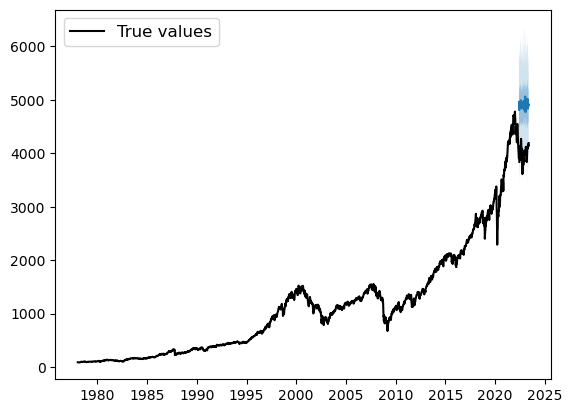

In [97]:
# Plot predictions
for ts in tss:
        plt.plot(ts.to_timestamp(), color="black")

# Plot forecast(s)
for forecast in forecasts:
    forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="large")

In [98]:
# Compute metrics
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
agg_metrics

Running evaluation: 1it [00:00,  6.10it/s]


{'MSE': 858815.127144788,
 'abs_error': 41215.720859375004,
 'abs_target_sum': 179205.91000000003,
 'abs_target_mean': 3982.3535555555563,
 'seasonal_error': 18.395279099956724,
 'MASE': 49.79021535956287,
 'MAPE': 0.23203788314090484,
 'sMAPE': 0.20690703453947942,
 'MSIS': 200.66233629465654,
 'QuantileLoss[0.1]': 16705.498728515628,
 'Coverage[0.1]': 0.8444444444444444,
 'QuantileLoss[0.5]': 41215.720859375004,
 'Coverage[0.5]': 1.0,
 'QuantileLoss[0.9]': 14764.440363281248,
 'Coverage[0.9]': 1.0,
 'RMSE': 926.7227887263742,
 'NRMSE': 0.23270731134194644,
 'ND': 0.22999085721768325,
 'wQuantileLoss[0.1]': 0.09321957478140996,
 'wQuantileLoss[0.5]': 0.22999085721768325,
 'wQuantileLoss[0.9]': 0.08238813308825164,
 'mean_absolute_QuantileLoss': 24228.553317057293,
 'mean_wQuantileLoss': 0.13519952169578162,
 'MAE_Coverage': 0.5,
 'OWA': nan}

In [99]:
# Store experiment run in database
experiment_config = Forecast_Experiment(
    model="torch_deepar",
    target=target_col,
    past_rts_col=str(past_rts_col),
    epochs=max_epochs,
    prediction_length=prediction_length,
    num_layers=num_layers,
    hidden_size=hidden_size,
    MASE=agg_metrics["MASE"],
    MAPE=agg_metrics["MAPE"],
    RMSE=agg_metrics["RMSE"],
    wQL_10=agg_metrics["wQuantileLoss[0.1]"],
    wQL_50=agg_metrics["wQuantileLoss[0.5]"],
    wQL_90=agg_metrics["wQuantileLoss[0.9]"],
    avg_wQL=agg_metrics["mean_wQuantileLoss"],
)
session.add(experiment_config)
session.commit()